<a href="https://colab.research.google.com/github/ed765super/DATA602-Baltimore-Crime-Data-Classification/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Powerpoint should be 5-10 slide summary
- Include results
- no technical charts

Video Clip
- can literally be you going through your slides
- just dont read directly off of the slides

(**Delete when done**)

#Background Information/Buisness Question

The Baltimore Police Agency launched a massive overhaul to its new Records Management Systems back in May 2020. The improvement will enable the department to migrate from a paper-based system to a completely digital reporting environment. As a consequence of this major shift, we had significant difficulties in appropriately transferring data from the new records system to the previous Open Data Baltimore system. The "Arrests" dataset is one of many open datasets made publicly accessible by Baltimore's police department on the city's Open Data website. This information is provided to us in order to foster more openness and data exchange between the local administration and its residents. This dataset contains arrest records for offenses such as assault, theft, and property damage in the City of Baltimore. [1]

I want to use their database create a model that predicts which district a crime occurs based on various details related to the arrest of the perpetrator such as what he or she was charged with, their gender, etc. My hope with this model is that the department can then use this model to efficiently spread their resources tackling the more likely arrests that would be made in a certain district as well as modify their policing efforts to decrease bias in said policing efforts in certain districts (if any).

[1] “Baltimore Police Department.” Crime Stats | Baltimore Police Department, https://www.baltimorepolice.org/crime-stats. 

#Accessing The Data
We begin where all great classification problems begin. Getting the data. Since I am using Google Colab for my analysis, I must upload Arrests.csv prior to actually importing it. Afterwards, I use a simple .read_csv method and check the general info of the dataframe so I know what im working with.

In [1]:
import pandas as pd
df = pd.read_csv('Arrests.csv', sep=',')
print(df.info())
print(df.describe(include='all'))
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175923 entries, 0 to 175922
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   X                  90128 non-null   float64
 1   Y                  90128 non-null   float64
 2   RowID              175923 non-null  int64  
 3   ArrestNumber       167697 non-null  float64
 4   Age                175836 non-null  float64
 5   Gender             175884 non-null  object 
 6   Race               175884 non-null  object 
 7   ArrestDateTime     175923 non-null  object 
 8   ArrestLocation     91488 non-null   object 
 9   IncidentOffence    175923 non-null  object 
 10  IncidentLocation   91488 non-null   object 
 11  Charge             156541 non-null  object 
 12  ChargeDescription  175923 non-null  object 
 13  District           89891 non-null   object 
 14  Post               89891 non-null   object 
 15  Neighborhood       89870 non-null   object 
 16  La

,X,Y,RowID,ArrestNumber,Age,Gender,Race,ArrestDateTime,ArrestLocation,IncidentOffence,IncidentLocation,Charge,ChargeDescription,District,Post,Neighborhood,Latitude,Longitude,GeoLocation,Shape
0,1.406788e+06,597678.129188,1,21000024.0,27.0,M,B,2020/12/31 23:50:00+00,2900 PRESBURY ST,96BINVESTIGATIVE STOP,2900 PRESBURY ST,1 0692,HAND GUN VIOLATION,Southwest,813,Northwest Community Action,39.3073,-76.6662,"(39.3073,-76.6662)",NaN
1,1.412063e+06,594601.943893,2,21000021.0,45.0,F,B,2020/12/31 23:45:00+00,900 MONROE ST,Unknown Offense,900 MONROE ST,2 0480,AUTO THEFT,Western,722,Midtown-Edmondson,39.2988,-76.6476,"(39.2988,-76.6476)",NaN
2,1.404120e+06,584046.130423,3,21000011.0,42.0,F,W,2020/12/31 23:40:00+00,1000 PINE HEIGHTS AVE,Unknown Offense,1000 PINE HEIGHTS AVE,1 1415,2ND DEGREE ASSAULT,Southwest,832,Violetville,39.2699,-76.6758,"(39.2699,-76.6758)",NaN
3,1.418872e+06,576745.235206,4,21000006.0,26.0,M,B,2020/12/31 21:45:00+00,700 CHERRY HILL RD,Unknown Offense,700 CHERRY HILL RD,1 0233,PWID,Southern,922,Cherry Hill,39.2497,-76.6238,"(39.2497,-76.6238)",NaN
4,1.418872e+06,576745.235206,5,21000014.0,19.0,M,B,2020/12/31 21:45:00+00,700 CHERRY HILL RD,Unknown Offense,700 CHERRY HILL RD,1 0233,PWID,Southern,922,Cherry Hill,39.2497,-76.6238,"(39.2497,-76.6238)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175918,1.435069e+06,601038.749707,175919,14000113.0,35.0,M,B,2014/01/01 00:05:00+00,3700 ELMORA AVE,Unknown Offense,3700 ELMORA AVE,1 1609,FIREARM VIOLATION,Northeast,432,Belair-Edison,39.3162,-76.5662,"(39.3162,-76.5662)",NaN
175919,1.405318e+06,589513.916091,175920,14000148.0,41.0,M,B,2014/01/01 00:05:00+00,3200 LOHRS LN,83DISCHARGING FIREARM,3200 LOHRS LN,1 5212,DISCHARGING,Southwest,835,Carroll-South Hilton,39.2849,-76.6715,"(39.2849,-76.6715)",NaN
175920,1.405318e+06,589513.916091,175921,14000140.0,36.0,F,B,2014/01/01 00:05:00+00,3200 LOHRS LN,83DISCHARGING FIREARM,3200 LOHRS LN,1 5212,DISCHARGING,Southwest,835,Carroll-South Hilton,39.2849,-76.6715,"(39.2849,-76.6715)",NaN
175921,1.405318e+06,589513.916091,175922,14000135.0,30.0,M,B,2014/01/01 00:05:00+00,3200 LOHRS LN,83DISCHARGING FIREARM,3200 LOHRS LN,1 5212,HGV,Southwest,835,Carroll-South Hilton,39.2849,-76.6715,"(39.2849,-76.6715)",NaN


No Errors are seen which means I can move on to the EDA

#EDA


**Exploratory Data Analysis or EDA** is one of the most important steps in Data Analysis. During this step the data analyst thouroughly examines the dataset to ensure it is in the form he needs for modeling.

Before doing anything I need to modify the data types to better represent the values in each of the columns

In [2]:
dfConverted = df.convert_dtypes()
dfConverted.dtypes

X                    float64
Y                    float64
RowID                  Int64
ArrestNumber           Int64
Age                    Int64
Gender                string
Race                  string
ArrestDateTime        string
ArrestLocation        string
IncidentOffence       string
IncidentLocation      string
Charge                string
ChargeDescription     string
District              string
Post                  string
Neighborhood          string
Latitude             float64
Longitude            float64
GeoLocation           string
Shape                  Int64
dtype: object

First thing I notice is that there are some features that will not contribute to my classification problem.
* 'X', 'Y', 'RowID', and 'ArrestNumber': are all similar indexing variables that will provide nothing to the classification
* 'ArrestLocation', 'IncidentLocation', 'Neighborhood': This wouldnt fit my classification problem as my model shouldnt need location information to determine the district the crime happened
* 'Latitude', 'Longitude', and 'GeoLocation' all provide the same information. This wouldnt fit my classification problem as my model shouldnt need location information to determine the district the crime happened
* 'Shape': Shape is a useless feature column that provides no information and is mostly filled with NA values 
* Charge, post: Charge and Charge Description hold what is basically the same information. Post is a 3 digit code relating to someone's charge. Thus when I throw them into a OHE they will provide redundancy which is bad. 

Therefore, I will drop those columns before moving on with the EDA

In [3]:
dfConverted = dfConverted.drop(['X', 'Y', 'RowID', 'ArrestNumber', 'ArrestLocation', 
              'IncidentLocation', 'Neighborhood', 'Latitude', 'Longitude',
              'GeoLocation', 'Shape', 'Charge', 'Post'], axis = 1)

In [4]:
print(dfConverted.dtypes)
dfConverted

Age                   Int64
Gender               string
Race                 string
ArrestDateTime       string
IncidentOffence      string
ChargeDescription    string
District             string
dtype: object


,Age,Gender,Race,ArrestDateTime,IncidentOffence,ChargeDescription,District
0,27,M,B,2020/12/31 23:50:00+00,96BINVESTIGATIVE STOP,HAND GUN VIOLATION,Southwest
1,45,F,B,2020/12/31 23:45:00+00,Unknown Offense,AUTO THEFT,Western
2,42,F,W,2020/12/31 23:40:00+00,Unknown Offense,2ND DEGREE ASSAULT,Southwest
3,26,M,B,2020/12/31 21:45:00+00,Unknown Offense,PWID,Southern
4,19,M,B,2020/12/31 21:45:00+00,Unknown Offense,PWID,Southern
...,...,...,...,...,...,...,...
175918,35,M,B,2014/01/01 00:05:00+00,Unknown Offense,FIREARM VIOLATION,Northeast
175919,41,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,DISCHARGING,Southwest
175920,36,F,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,DISCHARGING,Southwest
175921,30,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,HGV,Southwest


I may want the date and the time seperate to cut down on the sparcity of the dummy matrix formed when one hot encoding. First I will check how many unique values are there vs the total values

In [5]:
print("There are", dfConverted.ArrestDateTime.count() - len(dfConverted.ArrestDateTime.unique()), "Non unique values")

There are 45088 Non unique values


This will cause unnessessary sparcity in the Dummy Matrix

So I will seperate the date and time and make them seperate columns. Then delete the old column since it'll only provide redundancy.

In [6]:
#Fromhttps://www.tutorialspoint.com/write-a-program-to-separate-date-and-time-from-the-datetime-column-in-python-pandas
dfConverted['date'] = pd.to_datetime(dfConverted['ArrestDateTime']).dt.date
dfConverted['time'] = pd.to_datetime(dfConverted['ArrestDateTime']).dt.time
dfConverted

,Age,Gender,Race,ArrestDateTime,IncidentOffence,ChargeDescription,District,date,time
0,27,M,B,2020/12/31 23:50:00+00,96BINVESTIGATIVE STOP,HAND GUN VIOLATION,Southwest,2020-12-31,23:50:00
1,45,F,B,2020/12/31 23:45:00+00,Unknown Offense,AUTO THEFT,Western,2020-12-31,23:45:00
2,42,F,W,2020/12/31 23:40:00+00,Unknown Offense,2ND DEGREE ASSAULT,Southwest,2020-12-31,23:40:00
3,26,M,B,2020/12/31 21:45:00+00,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
4,19,M,B,2020/12/31 21:45:00+00,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
...,...,...,...,...,...,...,...,...,...
175918,35,M,B,2014/01/01 00:05:00+00,Unknown Offense,FIREARM VIOLATION,Northeast,2014-01-01,00:05:00
175919,41,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00
175920,36,F,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00
175921,30,M,B,2014/01/01 00:05:00+00,83DISCHARGING FIREARM,HGV,Southwest,2014-01-01,00:05:00


In [7]:
dfConverted = dfConverted.drop('ArrestDateTime', axis=1)

In [8]:
dfConverted

,Age,Gender,Race,IncidentOffence,ChargeDescription,District,date,time
0,27,M,B,96BINVESTIGATIVE STOP,HAND GUN VIOLATION,Southwest,2020-12-31,23:50:00
1,45,F,B,Unknown Offense,AUTO THEFT,Western,2020-12-31,23:45:00
2,42,F,W,Unknown Offense,2ND DEGREE ASSAULT,Southwest,2020-12-31,23:40:00
3,26,M,B,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
4,19,M,B,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
...,...,...,...,...,...,...,...,...
175918,35,M,B,Unknown Offense,FIREARM VIOLATION,Northeast,2014-01-01,00:05:00
175919,41,M,B,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00
175920,36,F,B,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00
175921,30,M,B,83DISCHARGING FIREARM,HGV,Southwest,2014-01-01,00:05:00


In [9]:
dfConverted.convert_dtypes()
print(dfConverted.dtypes)

Age                   Int64
Gender               string
Race                 string
IncidentOffence      string
ChargeDescription    string
District             string
date                 object
time                 object
dtype: object


Whiledate and time being objects seems wrong to me, They should be comparable to other objects within the column. Which is satisfactory enough for the one hot encoder. Thus I will leave them as is.

## Dealing with my NA values
Now that I have all the relavent columns for my classification, I need to ensure that the values in said column are not going to cause my modeling pipeline issues.

I will begin by first checking how many NA values I have in each column

In [10]:
print(dfConverted.isna().sum())

Age                     87
Gender                  39
Race                    39
IncidentOffence          0
ChargeDescription        0
District             86032
date                     0
time                     0
dtype: int64


I seem to have a couple NA values in Age, Gender, and Race (Ignore District for now). Due to the sheer size of the data, I can fill those with a value to denote that they were "unknown". But if they already have a value denoting "unknown" that would muddy the purity of the data. So before making that modification, I'll check for unique values for gender and race.
- If **age** has no "unknown" value already then substituting 0 for all
non positive age should suffice
  - I will check this by simply checking if all ages are positive numbers
- Gender should have 2 unique values. If it does then I know that NA values are most likely due to the gender being unknown at the time of the arrest according to my father who is a correctional officer
- Similarly I will check the unique values of each of the values in race. If the values all relate to a particular race and/or contain a letter denoting "other race", I will consider my "unknown" hypothesis to be true and will modify the NAs accordingly.

####I will begin with **Gender** since that is the easiest

In [11]:
print("There are", len(dfConverted.Gender.unique()), "Non unique values")
dfConverted.Gender.unique()

There are 3 Non unique values


<StringArray>
['M', 'F', <NA>]
Length: 3, dtype: string

My Hypothesis is correct, thus I will change all NA values to 'U' to denote that they were unknown.

In [12]:
dfConverted['Gender'] = dfConverted['Gender'].fillna('U')

In [13]:
dfConverted['Gender'].unique()

<StringArray>
['M', 'F', 'U']
Length: 3, dtype: string

####**Age** will be handled similarly

In [14]:
dfConverted.Age.unique()

<IntegerArray>
[  27,   45,   42,   26,   19,   18,   38,   33,   29,   35,   31,   23,   40,
   61,   43,   36,   32,   55,   48,   16,   17,   21,   57,   64,   34,   56,
   52,   25,   69,   41,   39,   30,   20,   37,   24,   44,   54,   22,   51,
   28,   46,   47,   53,   50,   62,   58,   49,   59,   63,   66,   67,   60,
   65,   71,   68,   70,   72,   75, <NA>,   76,   73,   74,   14,   15,   78,
   81,   80,   79,   77,   85,   82,   87,   83,  100,   84,   88]
Length: 76, dtype: Int64

In [15]:
dfConverted['Age'] = dfConverted['Age'].fillna(0)
dfConverted.Age.unique()

<IntegerArray>
[ 27,  45,  42,  26,  19,  18,  38,  33,  29,  35,  31,  23,  40,  61,  43,
  36,  32,  55,  48,  16,  17,  21,  57,  64,  34,  56,  52,  25,  69,  41,
  39,  30,  20,  37,  24,  44,  54,  22,  51,  28,  46,  47,  53,  50,  62,
  58,  49,  59,  63,  66,  67,  60,  65,  71,  68,  70,  72,  75,   0,  76,
  73,  74,  14,  15,  78,  81,  80,  79,  77,  85,  82,  87,  83, 100,  84,
  88]
Length: 76, dtype: Int64

####Finally I will handle **Race**

In [16]:
dfConverted.Race.unique()

<StringArray>
['B', 'W', 'U', 'A', 'I', <NA>]
Length: 6, dtype: string

It seems I was incorrect in my assumption on what the NAs meant. Since the About page for the dataset has no information regarding what each of the letters mean, I went to my father who has been a correctional officer for over 30 years. He confirmed the following:
- B = Black
- W = White
- U = Unknown at time of arrest
- A = Asian
- I = Indian (Middle Eastern)

This leads me to believe that 'NA' was actually used as the "other" catagory rather than the "unknown catagory. So I will replace the NAs with an 'O' instead.

In [17]:
dfConverted['Race'] = dfConverted['Race'].fillna('O')
dfConverted.Race.unique()

<StringArray>
['B', 'W', 'U', 'A', 'I', 'O']
Length: 6, dtype: string

##NAs in my target Variable

The initial NA check provided one more Row with an astonishing amount of NA values, My target column, District. Since the anount of NA values are so large and since its the target column for my classification, the resolution of this issue will require a more nuanced approach.

After discussing the issue with my professor, I've descided to take a semi-supervised approach to handling the NA values.

###Why Removing all rows with an NA value for my target feature is a bad idea
One question I asked myself when desciding whether to take a Semi-supervised approach or not is: "Why not just delete all the rows where the district is NA?"

Lets look at what happens if I take that approach

In [18]:
dfConverted.query('District.notna()', engine='python')

,Age,Gender,Race,IncidentOffence,ChargeDescription,District,date,time
0,27,M,B,96BINVESTIGATIVE STOP,HAND GUN VIOLATION,Southwest,2020-12-31,23:50:00
1,45,F,B,Unknown Offense,AUTO THEFT,Western,2020-12-31,23:45:00
2,42,F,W,Unknown Offense,2ND DEGREE ASSAULT,Southwest,2020-12-31,23:40:00
3,26,M,B,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
4,19,M,B,Unknown Offense,PWID,Southern,2020-12-31,21:45:00
...,...,...,...,...,...,...,...,...
175917,27,M,B,Unknown Offense,HANDGUN VIOLATION,Northeast,2014-01-01,00:05:00
175918,35,M,B,Unknown Offense,FIREARM VIOLATION,Northeast,2014-01-01,00:05:00
175919,41,M,B,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00
175920,36,F,B,83DISCHARGING FIREARM,DISCHARGING,Southwest,2014-01-01,00:05:00


We went from 175923 rows down to 89891.

That is a significant loss in data that I can use to train the model.

Thus I will leave the district how it is and take a semi-supervised approach during the Modeling, Processing, and Cleaning step later

##Basic Info about the Database
For now I will begin gathering basic info on my new datafram by checking the 5 number summary for each of my features

In [19]:
print(dfConverted.dtypes)
print(dfConverted.describe(include='all').T)

Age                   Int64
Gender               string
Race                 string
IncidentOffence      string
ChargeDescription    string
District             string
date                 object
time                 object
dtype: object
                    count unique                top    freq  ...  25%  50%  75%  max
Age                175923    NaN                NaN     NaN  ...   24   30   40  100
Gender             175923      3                  M  142091  ...  NaN  NaN  NaN  NaN
Race               175923      6                  B  144592  ...  NaN  NaN  NaN  NaN
IncidentOffence    175923    172    Unknown Offense   91417  ...  NaN  NaN  NaN  NaN
ChargeDescription  175923   7028  FAILURE TO APPEAR   27580  ...  NaN  NaN  NaN  NaN
District            89891      9           Southern   11771  ...  NaN  NaN  NaN  NaN
date               175923   2866         2014-01-09     177  ...  NaN  NaN  NaN  NaN
time               175923   1440           11:00:00    2834  ...  NaN  NaN  NaN  N

In [20]:
print("Arrest Data is logged from: ", dfConverted.time.min(), "to ", dfConverted.time.max())


Arrest Data is logged from:  00:00:00 to  23:59:00


In [21]:
print("Arrest Data Is collected All day from: ")
print(dfConverted.date.min())
print("To")
print(dfConverted.date.max())

Arrest Data Is collected All day from: 
2014-01-01
To
2021-11-05


####5 Number Summary Analysis
Just from the 5 number summary alone, we got a wealth of information:
- The most common way to get arrested is to not show up to your appointed court date. Whether its a major or minor offence, one should always try to make their court date.
- Most arrests seem to be made around 11am.
- The most amount of arrests made on a single day was on January 9th 2014
- In the 7 years this data spans, the black males are the most likely to be arrested. There are many articles backing up policing bias that contributed to this trend. I will leave some articles below.

###### What happened on January 9th 2014

In [22]:
startdate = pd.to_datetime("2014-01-08").date()
enddate = pd.to_datetime("2014-01-09").date()
dfLargeArrests = dfConverted[(dfConverted['date'] > startdate) & (dfConverted['date'] <= enddate)]
#I wanna view all rows so I will modify pandas default viewing size
pd.set_option('display.max_rows', dfConverted.shape[0]+1)
dfLargeArrests

,Age,Gender,Race,IncidentOffence,ChargeDescription,District,date,time
171946,51,M,B,87NARCOTICS,CDS VIOLATION,Central,2014-01-09,23:55:00
171947,34,M,B,Unknown Offense,FAILURE TO APPEAR,<NA>,2014-01-09,23:44:00
171948,37,M,B,97SEARCH & SEIZURE,VOP,<NA>,2014-01-09,23:19:00
171949,53,M,W,97SEARCH & SEIZURE,CDS,Southern,2014-01-09,22:45:00
171950,46,M,B,87NARCOTICS,CDS,Central,2014-01-09,22:45:00
171951,34,M,B,87NARCOTICS,POSSESSION OF MARIJUANA,Eastern,2014-01-09,22:30:00
171952,22,M,B,6CLARCENY- SHOPLIFTING,CDS,Eastern,2014-01-09,22:30:00
171953,49,M,B,6CLARCENY- SHOPLIFTING,TRESPASS/LARCENCY,Eastern,2014-01-09,22:20:00
171954,57,M,B,Unknown Offense,VIOLATION OF PROBATION,<NA>,2014-01-09,22:03:00
171955,57,M,B,Unknown Offense,FAILURE TO APPEAR,<NA>,2014-01-09,22:03:00


Lets print a summary of what occured on that day

In [23]:
#Setting this back to 10 for sanity reasons
pd.set_option('display.max_rows', 10)
print(dfLargeArrests.describe(include='all').T)

                  count unique              top freq  ...  25%  50%  75%  max
Age                 177    NaN              NaN  NaN  ...   22   27   40   67
Gender              177      2                M  144  ...  NaN  NaN  NaN  NaN
Race                177      3                B  150  ...  NaN  NaN  NaN  NaN
IncidentOffence     177     22  Unknown Offense   69  ...  NaN  NaN  NaN  NaN
ChargeDescription   177     79    CDS VIOLATION   24  ...  NaN  NaN  NaN  NaN
District            113      9        Southeast   20  ...  NaN  NaN  NaN  NaN
date                177      1       2014-01-09  177  ...  NaN  NaN  NaN  NaN
time                177    107         21:00:00    5  ...  NaN  NaN  NaN  NaN

[8 rows x 11 columns]


In [24]:
n = 10
dfConverted['ChargeDescription'].value_counts()[:n].index.tolist()

['FAILURE TO APPEAR',
 'ASSAULT-SEC DEGREE',
 'CDS VIOLATION',
 'CDS',
 'Unknown Charge',
 'COMMON ASSAULT',
 'VIOLATION OF PROBATION',
 'HGV',
 'ASSAULT-FIRST DEGREE',
 'ASSAULT']

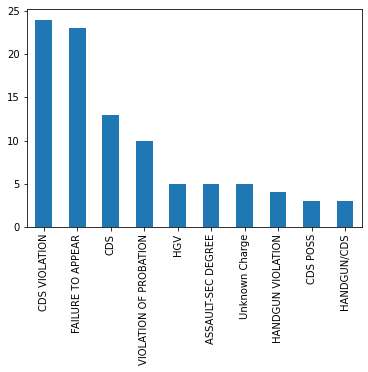

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
dfLargeArrests['ChargeDescription'].value_counts()[:n].plot.bar()

Disregarding "Faliure To Appear", it seems most of these arrests were  CDS aka Controlled Dangerous Substance charges. This makes sense as people are comming off of the holidays at this point. Perhaps they are trying out their new "preasents"

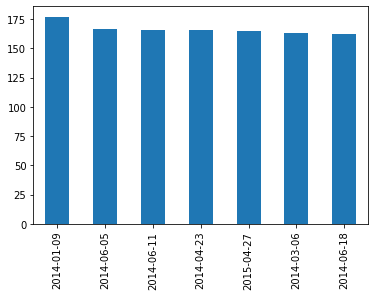

In [26]:
n=7
dfConverted['date'].value_counts()[:n].plot.bar()

This is Furthur backed up by the chart above. Arrests seem to occur
- a couple days following holidays like christmas or easter
- a couple days after pseudo holidays like 4/20 (weed day)
- and in warmer months like June when people are more out and about.

Next I will gather a visual summary of my numerical data

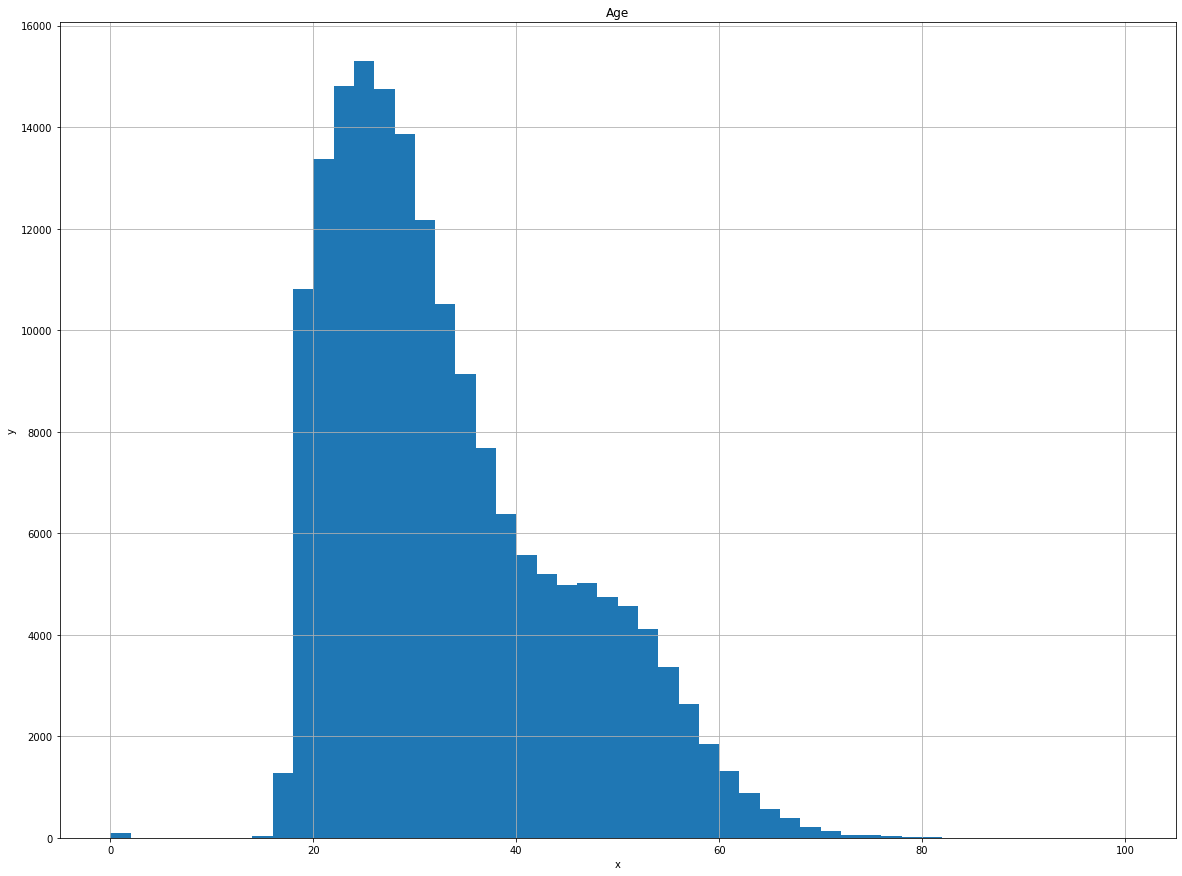

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

axes = dfConverted[['Age','Gender','Race','IncidentOffence', 'ChargeDescription', 'District', 'date', 'time']].hist(bins=50, figsize=(20,15))
#Learned how to do the for loop for multi graph labeling here: https://stackoverflow.com/questions/69329880/how-do-i-label-the-x-y-axis-of-multiple-graphs-on-a-single-graph/69329975#69329975
for ax in axes[0]:
  ax.set_xlabel('x')
  ax.set_ylabel('y')
plt.show()

Seems most Baltimore residents are being arrested in their mid twenties with a less noticable hump occuring in their late 40s.
- There are many factors that can play into why kids in their mid 20s are being arrested as a professor of criminal justice told the new york times [2]

[2] https://www.nytimes.com/2011/12/19/us/nearly-a-third-of-americans-are-arrested-by-23-study-says.html

####Multicolinearity check
Since descision trees are one of the methods I want to attempt to apply, I need to make sure that the columns are not highly correlated to each other.

So the first thing I'll check for is if there is any multicoliniarity in my numerical data

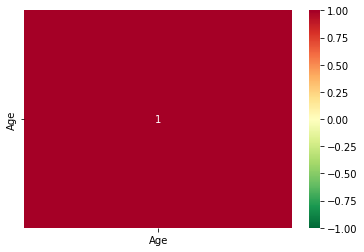

In [ ]:
import seaborn as sns
sns.heatmap(dfConverted.corr(),cmap='RdYlGn_r', annot=True, vmin=-1.0, vmax=1.0)
plt.show()

I only have 1 numerical Variable so it would make sense that it is fully correlated with itself.

But how would I check for multicolinearity with my other variables?
Accorfing to Deepanshu Bhalla of listendata.com[3], "For categorical variables, multicollinearity can be detected with Spearman rank correlation coefficient for ordinal variables and chi-square test for nominal variables."

A nominal variable has no inherent ordering. Race, for example, is a categorical variable because there are 6 categories (w, B, A, I, U, and most recently O) and you cant place an order on them in an order naturally.

A variable with an ordinal value has a distinct ordering. The date and time columns would both be ordinal as the objects have a clear timeline. i.e. 2014-01-09	coomes before 2014-01-10 and 03:40:00 is earlier than 11:00:00	

[3] https://www.listendata.com/2015/04/detecting-multicollinearity-in-categorical-variables.html

#####Spearman rank correlation
Below Is a seaborn plot checking for multicolinearity between date and time

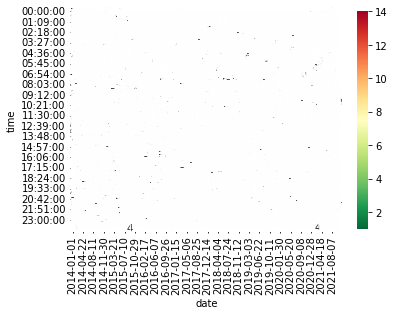

In [ ]:
import seaborn as sns
#Adopted from here: https://stackoverflow.com/questions/53014323/plotting-a-heatmap-with-categorical-data
year = 'date'
bins = 'time'
Firm = 'Age'
grouped = dfConverted.groupby([year,bins]).nunique()[Firm].reset_index([0,1])
piv_grouped = grouped.pivot(index=bins, columns=year, values=Firm)
sns.heatmap(piv_grouped, cmap='RdYlGn_r', annot=True)

A majority of the heatmap is green which means there is no multicoliniarity

#####chi-square test
The easiest way to perform a Chi-Square Test is to create a contingency table from the frequency of values[4]
I'll begin with checking the multicoliniarity between Gender and Race

[4] https://predictivehacks.com/how-to-run-chi-square-test-in-python/

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
contigency= pd.crosstab(dfConverted['Gender'], dfConverted['Race'])
contigency

Race,A,B,I,O,U,W
Gender,,,,,,
F,111,24286,76,0,499,8821
M,332,120306,421,0,3457,17575
U,0,0,0,39,0,0


Thise just look like a bunch of numbers to me. So I will vreate a heatmap to visualize it more easily

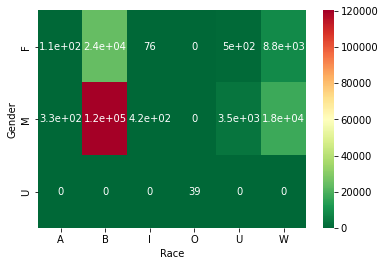

In [ ]:
sns.heatmap(contigency, annot=True, cmap="RdYlGn_r")

In [ ]:
# Chi-square test of independence.
c, p, dof, expected = chi2_contingency(contigency)
p

0.0

The p-value here is 0% which means that we do not reject the null hypothesis at 95% level of confidence.[4] The null hypothesis was that Gender and Race are independent. Therefore now know that Gender and race are completely independent from each other. 

Now lets compare the other nominal variables (incident offence and charge description) to and determine p statistics for all of them.



In [ ]:
contigencyGI= pd.crosstab(dfConverted['Gender'], dfConverted['IncidentOffence'])
contigencyGC= pd.crosstab(dfConverted['Gender'], dfConverted['ChargeDescription'])
contigencyRI= pd.crosstab(dfConverted['Race'], dfConverted['IncidentOffence'])
contigencyRC= pd.crosstab(dfConverted['Race'], dfConverted['ChargeDescription'])
contigencyCI= pd.crosstab(dfConverted['ChargeDescription'], dfConverted['IncidentOffence'])

c, GIpStat, dof, expected = chi2_contingency(contigencyGI)
c, GCpStat, dof, expected = chi2_contingency(contigencyGC)
c, RIpStat, dof, expected = chi2_contingency(contigencyRI)
c, RCpStat, dof, expected = chi2_contingency(contigencyRC)
c, CIpStat, dof, expected = chi2_contingency(contigencyCI)

print("Pstat btwn Gender and Incident Offecnce is: ", GIpStat)
print("Pstat btwn Gender and Charge Description is: ", GCpStat)
print("Pstat btwn Race and Incident Offecnce is: ", RIpStat)
print("Pstat btwn Race and Charge Description is: ", RCpStat)
print("Pstat btwn Charge Description and Incident Offecnce is: ", CIpStat)

Pstat btwn Gender and Incident Offecnce is: %f 0.0
Pstat btwn Gender and Charge Description is: %f 9.044134031092239e-170
Pstat btwn Race and Incident Offecnce is: %f 0.0
Pstat btwn Race and Charge Description is: %f 1.4298290944869867e-265
Pstat btwn Charge Description and Incident Offecnce is: %f 0.0


All of my nominal variables have little to no multicolliniarity with each other

#Modeling, Preprocessing, and cleaning


With the comletion of the EDA, I will move on to modeling.

First lets remind ourselves of what columns we're working with

In [39]:
print(dfConverted.dtypes)
print(print(dfConverted.isna().sum()))

Age                   Int64
Gender               string
Race                 string
IncidentOffence      string
ChargeDescription    string
District             string
date                 object
time                 object
dtype: object
Age                      0
Gender                   0
Race                     0
IncidentOffence          0
ChargeDescription        0
District             86032
date                     0
time                     0
dtype: int64
None


####Splitting Training and Test sets

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#First grab all the relvent columns and put em in lists
numericalColumns = dfConverted.select_dtypes(include=['Int64'])
nonNumericColumns = dfConverted.select_dtypes(exclude=['Int64'])

cat_vars = []
num_vars = []

#This is to make sure I dont include the target variable.
for col in numericalColumns.columns:
      num_vars.append(col)
for col in nonNumericColumns.columns:
  if col != 'District':
    cat_vars.append(col)

#Check to ensure I have everything I want
print("categorical variable list = ", cat_vars)
print("numerical variable list = ", num_vars)


#Regardless of what methodology I go with, I am going to have to standardize
#I know there is no missing data in the Age column so I dont need to impute missing
num_pipeline = Pipeline([('standardize_num', StandardScaler())
                        ])

num_transformer = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars)])

cat_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='ignore'))])

#I think im not doing this tuple correctly. I think this is why the imputing never happens
processing_pipeline = ColumnTransformer(transformers=[('adjust_cats', cat_pipeline, cat_vars),
                                                      ('proc_numeric', num_pipeline, num_vars)
                                                      
                                                     ]
                                        )

print(processing_pipeline)

categorical variable list =  ['Gender', 'Race', 'IncidentOffence', 'ChargeDescription', 'date', 'time']
numerical variable list =  ['Age']
ColumnTransformer(transformers=[('adjust_cats',
                                 Pipeline(steps=[('create_dummies_cats',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Race', 'IncidentOffence',
                                  'ChargeDescription', 'date', 'time']),
                                ('proc_numeric',
                                 Pipeline(steps=[('standardize_num',
                                                  StandardScaler())]),
                                 ['Age'])])


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfConverted[num_vars+cat_vars], dfConverted["District"], test_size=0.25)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 131,942
Test examples: 43,981


##### Semi Supervised Learning

Due to the large number of missing variables in my target column, I should take a semi-supervised approach to imputing values

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

p = Pipeline([('sc', StandardScaler()),
             ('kmeans', KMeans(n_clusters=100)),
              ('logreg', LogisticRegression(solver='liblinear'))])

p = processing_pipeline.fit(X_train, y_train)
p_score = p.score(X_test, y_test)
print(f'Using k-means preprocesser: {p_score:.2%}')

AttributeError: ignored

In [38]:
n_labeled = 50

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

small_n_score = log_reg.score(X_test, y_test)
print(f'Accuracy with only 50 training examples: {small_n_score:.2%}')

ValueError: ignored

In [37]:
log_reg = LogisticRegression(solver='liblinear')
log_reg = log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
print(f'Score: {log_reg_score:.2%}')

ValueError: ignored

Now I will fit Fit a logistic regression, decision tree, and SVM using grid search

First I will set up the pipeline

Logistic Regression with grid search

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()
p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

#Select various correlation strengths with a magnitude of 10
params = {'lr__C': [.001, 0.01, 0.1, 1, 10, 100]}

#I will score based on accurancy as that the dataset is not heavily skewed
lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)

lr_gscv = lr_gscv.fit(X_train, y_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(X_test)

print(f'Test score: {lr_gscv.score(X_test, y_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

TypeError: ignored

Furthur Refined Logistic Grid Search

Now that we know the best correlation strength is around __, I am going to run it again with values closer to __ to ensure I have the best correlation strength possible

In [ ]:
start_time = time.time()
p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

#Select various correlation strengths with a magnitude of 10
params = {'lr__C': [.001, 0.01, 0.1, 1, 10, 100]}

#I will score based on accurancy as that the dataset is not heavily skewed
lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)

lr_gscv = lr_gscv.fit(X_train, y_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(tX_test)

print(f'Test score: {lr_gscv.score(X_test, y_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Descision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(X_train, y_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(X_test)

print(f'Test score: {dt_gscv.score(X_test, y_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 64.59%
Test score: 62.70%
Runtime:  43.282294034957886  seconds


Further Refined DT Grid Search

In [ ]:
start_time = time.time()

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(X_train, y_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(X_test)

print(f'Test score: {dt_gscv.score(X_test, y_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()
svm_m = modeling_pipeline = Pipeline([('processing', processing_pipeline),
                                      ('scaling', StandardScaler(with_mean=False)),
                                       ('model', SVC())])


param_grid = [
  {'model__C': [0.1, 1, 10, 100], 'model__kernel': ['rbf']}
 ]

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, cv=10, scoring='accuracy', refit=True)
svm_results = svm_results.fit(tX_train, ty_train)

print(f'Validation score: {svm_results.best_score_:.2%}')

svm_pred = svm_results.predict(tX_test)

print(f'Test score: {svm_results.score(X_test, y_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 64.92%
Test score: 65.09%
Runtime:  195.7040295600891  seconds


Further Refined SVM Grid Search

In [47]:
start_time = time.time()
svm_m = modeling_pipeline = Pipeline([('processing', processing_pipeline),
                                      ('scaling', StandardScaler(with_mean=False)),
                                       ('model', SVC())])


param_grid = [
  {'model__C': [0.1, 1, 10, 100], 'model__kernel': ['rbf']}
 ]

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, cv=10, scoring='accuracy', refit=True)
svm_results = svm_results.fit(X_train, y_train)

print(f'Validation score: {svm_results.best_score_:.2%}')

svm_pred = svm_results.predict(tX_test)

print(f'Test score: {svm_results.score(tX_test, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

NameError: ignored

#Results and discussion


#Fit an ensemble using the three above models.

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
clf3 = svm.SVC(probability=True)

pipe1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])
pipe2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])
pipe3 = Pipeline([('processing', processing_pipeline),
                ('scaling', StandardScaler(with_mean=False)),
                ('model', SVC())])

labs = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine']
clfs = [pipe1, pipe2, pipe3]
clfs = zip(labs, clfs)

for lab, clf in clfs:
    scores = cross_val_score(estimator=clf, X=tX_train, y=ty_train, cv=10, scoring='accuracy')
    print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [{lab}]')

Accuracy 0.68 (+/- 0.02) [Logistic Regression]
Accuracy 0.59 (+/- 0.02) [Decision Tree]
Accuracy 0.63 (+/- 0.01) [Support Vector Machine]


In [ ]:
from sklearn.ensemble import VotingClassifier

ems = [('lr', pipe1),('dt', pipe2),('model', pipe3)]
#Changing voting to hard because SVM doesnt use probabilities
#so using the mode is ok
clf4 = VotingClassifier(estimators= ems, weights=None, voting='hard')

scores = cross_val_score(estimator=clf4, X=tX_train, y=ty_train, cv=10, scoring='accuracy')
print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')

Accuracy 0.66 (+/- 0.01) [Ensemble]


ADA BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
start_time = time.time()
# multi-step pipelines don't play as nice with AdaBoost
xt = processing_pipeline.fit_transform(tX_train)

params = {'n_estimators': [50, 100, 200, 500, 1000]
         }

#ABC = AdaBoostClassifier(base_estimator=p2)
ABC = AdaBoostClassifier(DecisionTreeClassifier())


ad_gscv = GridSearchCV(ABC, param_grid = params, cv=10, scoring='accuracy')
           
ad_gscv = ad_gscv.fit(xt, ty_train)

print(f'Validation score: {ad_gscv.best_score_:.2%}')

xtt = processing_pipeline.transform(tX_test)

ad_pred = ad_gscv.predict(xtt)

print(f'Test score: {ad_gscv.score(xtt, ty_test):.2%}')
print ("Runtime: ", time.time() - start_time, " seconds")

Validation score: 58.57%
Test score: 58.34%
Runtime:  23.792025566101074  seconds


#Discuss the performance of each model.
* Logistic Regression had the highest accuracy score and took the least amount of time to run
* SVM took the longest despite searching over less correlation strengths. This is most likely due to the immense ammount of copies being created during SVM
* Descision Trees had the lowest accuracy score

#Conclusion/next steps
